In [134]:
# Generate test observations
from bilby.gw import source, conversion

run = 'highSNR'

sourced = dict(
    source_type = 'BBH',
    aligned_spins = False,
    fd_source_model = source.lal_binary_black_hole,
    param_conversion_model = conversion.convert_to_lal_binary_black_hole_parameters,
)

waveform_params = dict(
    sampling_frequency = 2048,
    duration = 4,
    start_offset = 2,
    start = -2,
    waveform_apprx = 'SEOBNRv4PHM',
    minimum_frequency = 20,
    maximum_frequency = 1024,
    reference_frequency = 50,
    ifo_list = ['H1','L1','V1'],
    ifo_noise = True,
)

injection = dict(
    mass_1 = 39.536,
    mass_2 = 34.872,
    mass_ratio = 0.8858,
    chirp_mass = 32.14,
    luminosity_distance = 200 if run=='highSNR' else 900,
    dec = 0.071,
    ra = 5.556,
    theta_jn = 0.4432,
    psi = 1.100,
    phase = 5.089,
    tilt_1 = 1.497,
    tilt_2 = 1.102,
    a_1 = 0.9702,
    a_2 = 0.8118,
    phi_12 = 6.220,
    phi_jl = 1.885,
    geocent_time = 0.0,
)

intrinsic_variables = ['mass_ratio', 'chirp_mass', 'luminosity_distance', 'dec', 'ra', 'theta_jn', 'psi', 'phase', 'tilt_1', 'tilt_2']
extrinsic_variables = ['a_1', 'a_2', 'phi_12', 'phi_jl', 'geocent_time']

conf = {
    'source' : sourced,
    'waveform_params' : waveform_params,
    'injection' : injection,
    'priors' : {
        'int_priors' : {key: injection[key] for key in intrinsic_variables},
        'ext_priors' : {key: injection[key] for key in extrinsic_variables},
    },
}


In [135]:
from sympy import symbols, solve

def get_masses(mass_ratio, chirp_mass):

    m1 = symbols('m1')
    m2 = mass_ratio * m1

    m1_solve = float( solve(((m1*m2)**(3/5)) / ((m1 + m2)**(1/5)) - chirp_mass, m1)[0] )
    m2_solve = mass_ratio * m1_solve

    return m1_solve, m2_solve

get_masses(0.8858, 32.14)

(39.241318679135915, 34.7599600859786)

In [136]:
import sys
import numpy as np

path_to_peregrine = '/home/scur2012/Thesis/Peregrine/peregrine/peregrine'
if path_to_peregrine not in sys.path:
    sys.path.append(path_to_peregrine)

from simulator_utils import Simulator

limits = dict(
    mass_ratio = [0.125,1.0],
    chirp_mass = [25,100],
    theta_jn = [0.0,3.14159],
    phase = [0.0,6.28318],
    tilt_1 = [0.0,3.14159],
    tilt_2 = [0.0,3.14159],
    a_1 = [0.05,1.0],
    a_2 = [0.05,1.0],
    phi_12 = [0.0,6.28318],
    phi_jl = [0.0,6.28318],
    luminosity_distance = [100,1500],
    dec = [-1.57079,1.57079],
    ra = [0.0,6.28318],
    psi = [0.0,3.14159],
    geocent_time = [-0.1,0.1],
)

number_of_samples = 5
time_domain = np.zeros((15, number_of_samples, 8192))
frequency_domain = np.zeros((15, number_of_samples, 4097))

for i, param in enumerate(limits.keys()):
    
    lower_limit = limits[param][0]
    upper_limit = limits[param][1]
    
    value_array = np.linspace(lower_limit, upper_limit, number_of_samples)
    
    for j, new_value in enumerate(value_array):
        
        new_injection = injection.copy()
        new_injection[param] = new_value
        
        if param == 'mass_ratio' or param == 'chirp_mass':
            new_injection['mass_1'] = round( get_masses(new_injection['mass_ratio'], new_injection['chirp_mass'])[0] ,2)
            new_injection['mass_2'] = round( get_masses(new_injection['mass_ratio'], new_injection['chirp_mass'])[1] ,2)
        
        new_conf = {
            'source' : sourced,
            'waveform_params' : waveform_params,
            'injection' : new_injection,
            'priors' : {
                'int_priors' : {key: new_injection[key] for key in intrinsic_variables},
                'ext_priors' : {key: new_injection[key] for key in extrinsic_variables},
            },
        }
        
        #print (param, new_injection[param])
        
        simulator = Simulator(new_conf)
        obs = simulator.generate_observation()
        
        time_domain[i,j] = obs['d_t'][0]
        frequency_domain[i,j] = obs['d_f'][0]
            

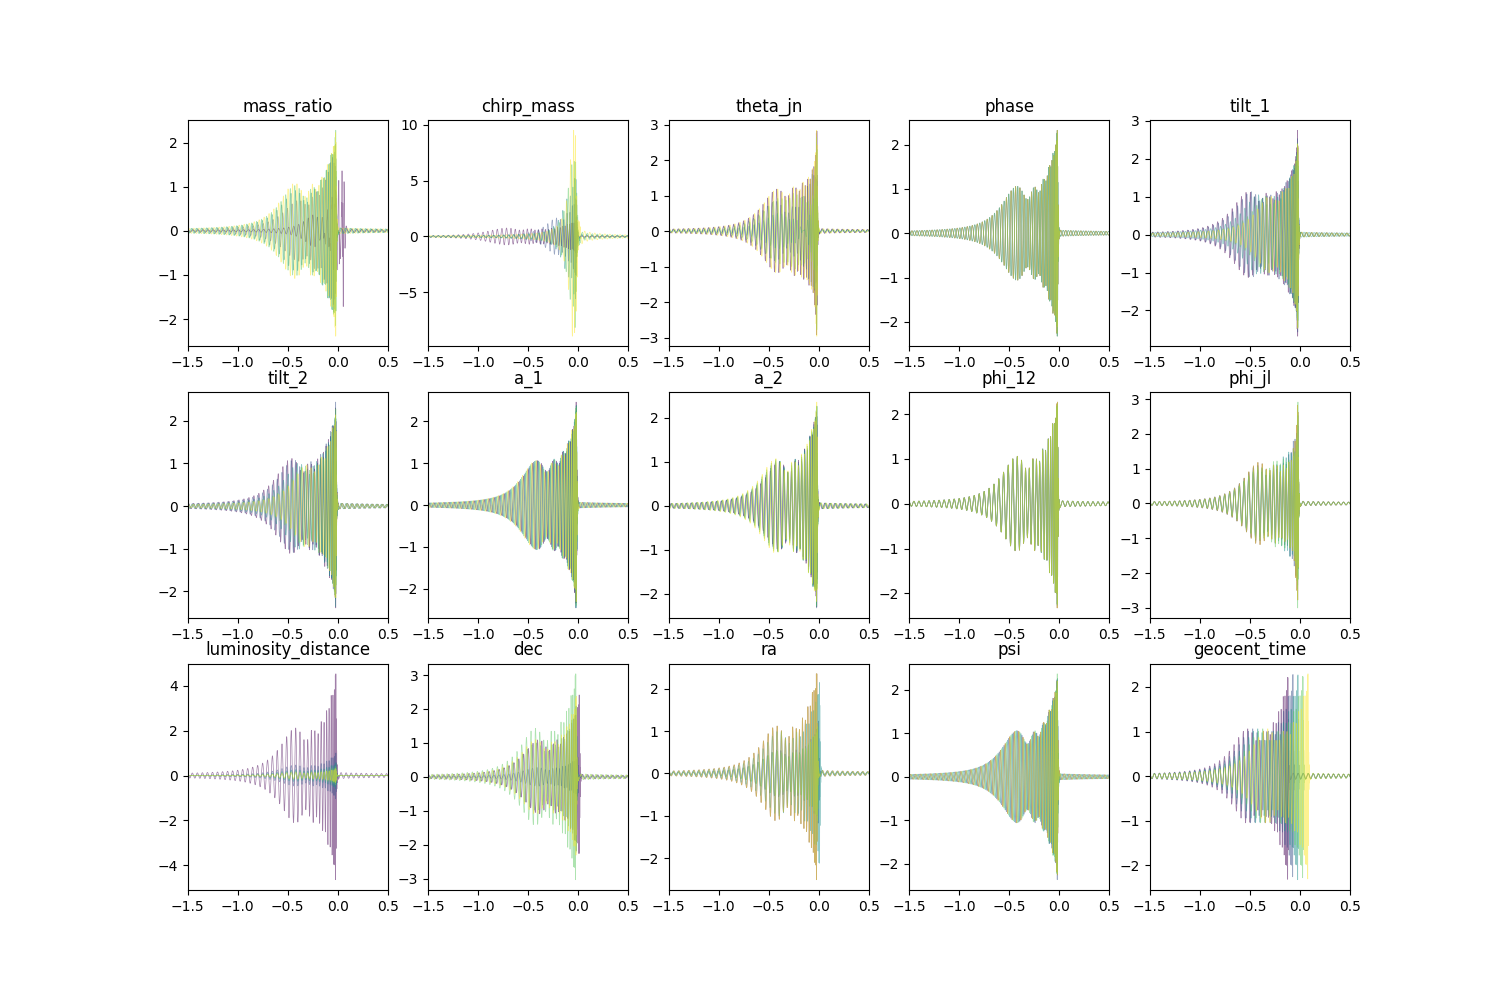

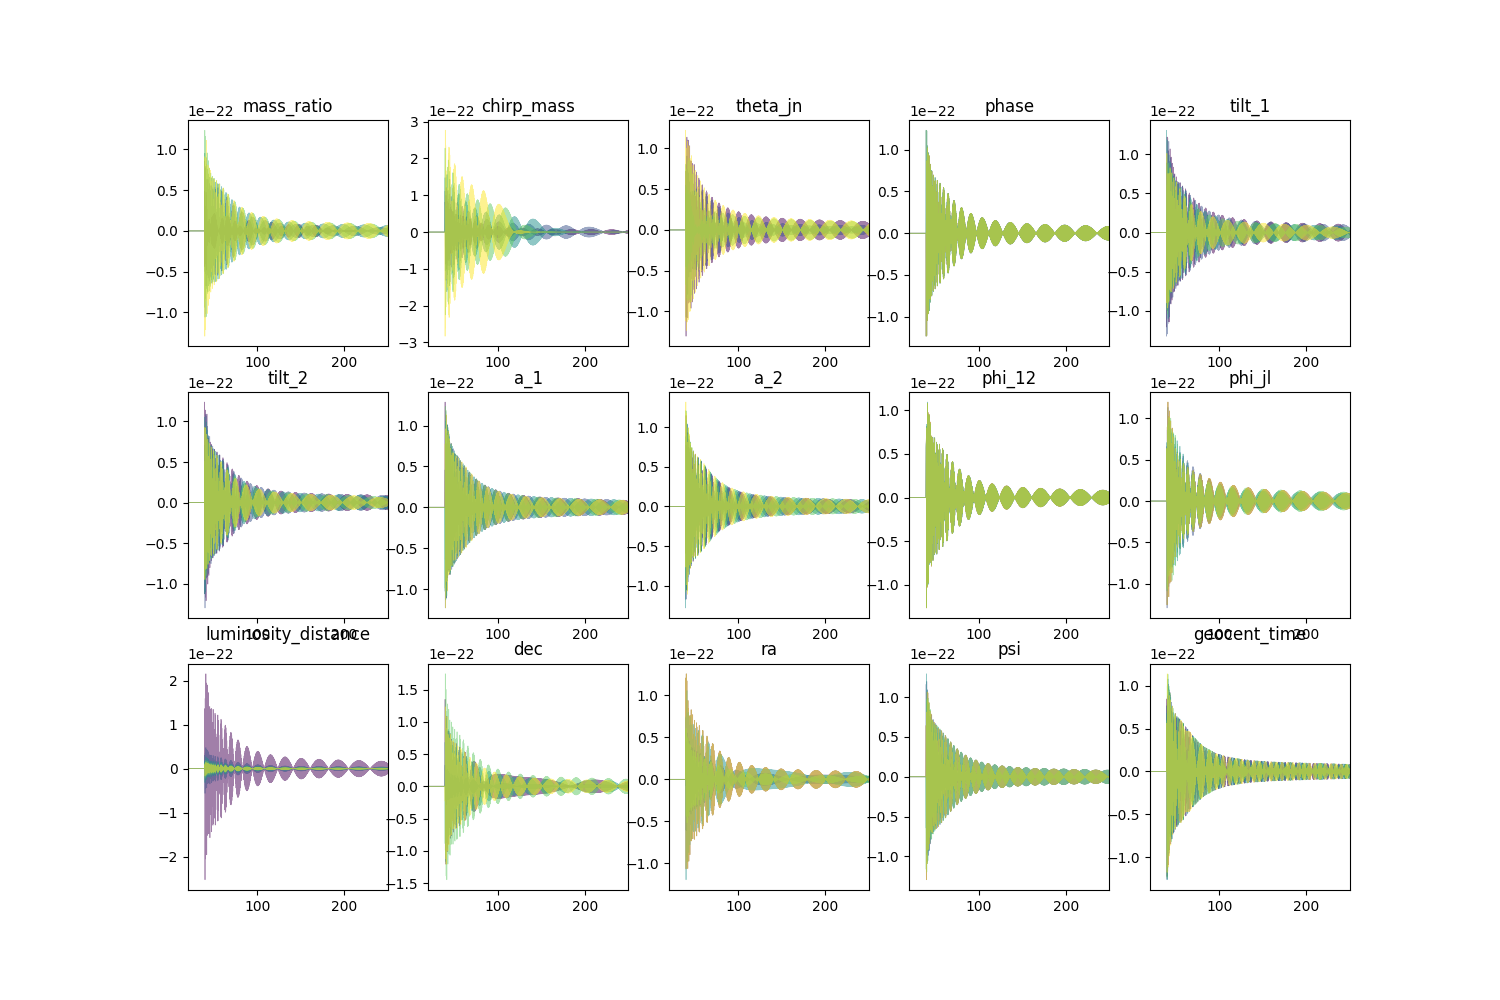

In [137]:
import matplotlib.pyplot as plt
plt.close('all')
%matplotlib widget

tvals = np.linspace(-2, 2, 2048*4+1)[:-1]
fvals = np.linspace(20, 1024, 4098)[:-1]

cmap = plt.cm.viridis
colors = [cmap(i) for i in np.linspace(0, 1, number_of_samples)]

plt.figure(figsize=(15, 10))
for i in range(15):
    
    ax = plt.subplot(3, 5, i + 1)
    for j in range(number_of_samples):
        
        plt.plot(tvals, time_domain[i,j], linewidth=0.5, color=colors[j], alpha=0.5)
    
    plt.title(list(limits.keys())[i])
    plt.xlim(-1.5,0.5)

plt.show()

plt.figure(figsize=(15, 10))
for i in range(15):
    
    ax = plt.subplot(3, 5, i + 1)
    for j in range(number_of_samples):
        
        plt.plot(fvals, frequency_domain[i,j], linewidth=0.5, color=colors[j], alpha=0.5)
    
    plt.title(list(limits.keys())[i])
    plt.xlim(20,250)

plt.show()